In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from scipy.stats import norm
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 8)

In [2]:
def computeLocalPUDensity(all_events_vertex_xs, delta_x):
    localPUdensity = []
    for vertex_xs in all_events_vertex_xs:
        localPUdensity.append((np.sum(np.abs(vertex_xs[0]-vertex_xs[1:]) < delta_x))/(2*delta_x))
    return localPUdensity
def computeAvgPUDensity(all_events_vertex_xs, mu=200, sigma_x=50):
    avgPUdensity = []
    for vertex_xs in all_events_vertex_xs:
        avgPUdensity.append(mu/(sigma_x*np.sqrt(2*np.pi)) * np.exp(-0.5*vertex_xs[0]**2/sigma_x**2))
    return avgPUdensity

In [3]:
# files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
files = ['../ntuples/ttbar/hist-Rel21sample.root']
track_t = np.array([], dtype='object')
track_z0 = np.array([], dtype='object')
track_z0_var = np.array([], dtype='object')
track_z = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
reco_vertex_track_weights = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')

reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')
truth_vertex_t = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_z0 = np.concatenate((track_z0, tree['track_z0'].array(library='np')))
            track_z0_var = np.concatenate((track_z0_var, tree['track_var_z0'].array(library='np')))
            track_z = np.concatenate((track_z, tree['track_z'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            reco_vertex_track_weights = np.concatenate((reco_vertex_track_weights, tree['recovertex_tracks_weight'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            
            reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))
            truth_vertex_t = np.concatenate((truth_vertex_t, tree['truthvertex_t'].array(library='np')))

In [4]:
track_z_flat = np.concatenate(track_z)
track_z0_flat = np.concatenate(track_z0)
diff_track_z = track_z0_flat-track_z_flat

delta_track_z_recoHS = np.array([])
delta_track_z_truthHS = np.array([])
for idx in range(len(track_z)):
    reco_idx = reco_vertex_track_idxs[idx][0]
    truth_idx = truth_vertex_track_idxs[idx][0]
    delta_track_z_recoHS = np.concatenate((delta_track_z_recoHS, track_z[idx][reco_idx] - track_z0[idx][reco_idx]))
    delta_track_z_truthHS = np.concatenate((delta_track_z_truthHS, track_z[idx][truth_idx] - track_z0[idx][truth_idx]))

Text(0.5, 0, 'Reco track z0 - truth track z [mm]')

findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.


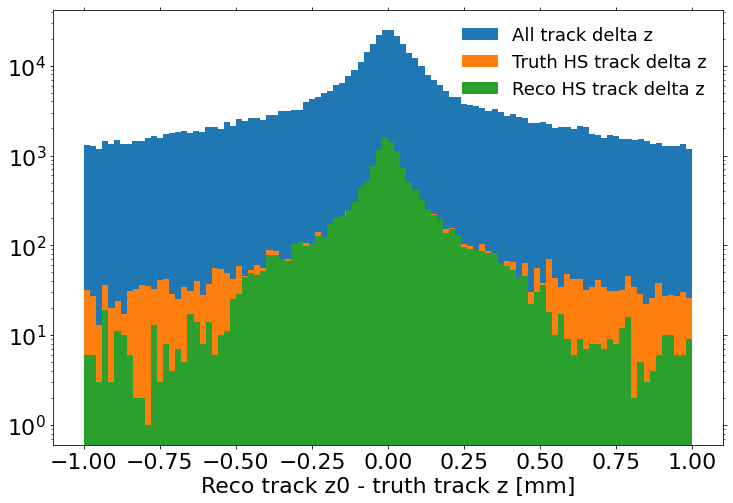

In [5]:
max_z = 1
_ = plt.hist(diff_track_z[np.abs(diff_track_z) < max_z], bins=100, label='All track delta z')
_ = plt.hist(delta_track_z_truthHS[np.abs(delta_track_z_truthHS) < max_z], bins=100, label='Truth HS track delta z')
_ = plt.hist(delta_track_z_recoHS[np.abs(delta_track_z_recoHS) < max_z], bins=100, label='Reco HS track delta z')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Reco track z0 - truth track z [mm]')

In [6]:
# cut >1 track pT
# plot vs track eta

In [7]:
## Find truth link via number of shared tracks
recoHS_to_truth_link_idx = []
truthHS_to_reco_link_idx = []
for event_idx in range(len(truth_vertex_t)):
    event_reco_to_truth_n_tracks = -1
    event_reco_to_truth_idx = -1
    reco_hs_track_idx = reco_vertex_track_idxs[event_idx][0]
    for i, truth_track_idxs in enumerate(truth_vertex_track_idxs[event_idx]):
        n = len(np.intersect1d(reco_hs_track_idx, truth_track_idxs))
        if n > event_reco_to_truth_n_tracks and i < 100:
            # print(event_idx, n)
            event_reco_to_truth_n_tracks = n
            event_reco_to_truth_idx = i
    
    event_truth_to_reco_n_tracks = -1
    event_truth_to_reco_idx = -1
    truth_hs_track_idx = truth_vertex_track_idxs[event_idx][0]
    for i, reco_track_idxs in enumerate(reco_vertex_track_idxs[event_idx]):
        n = len(np.intersect1d(truth_hs_track_idx, reco_track_idxs))
        if n > event_truth_to_reco_n_tracks and i < 100:
            # print(event_idx, n)
            event_truth_to_reco_n_tracks = n
            event_truth_to_reco_idx = i
    
    recoHS_to_truth_link_idx.append(event_reco_to_truth_idx)
    truthHS_to_reco_link_idx.append(event_truth_to_reco_idx)
recoHS_to_truth_link_idx = np.array(recoHS_to_truth_link_idx)
truthHS_to_reco_link_idx = np.array(truthHS_to_reco_link_idx)

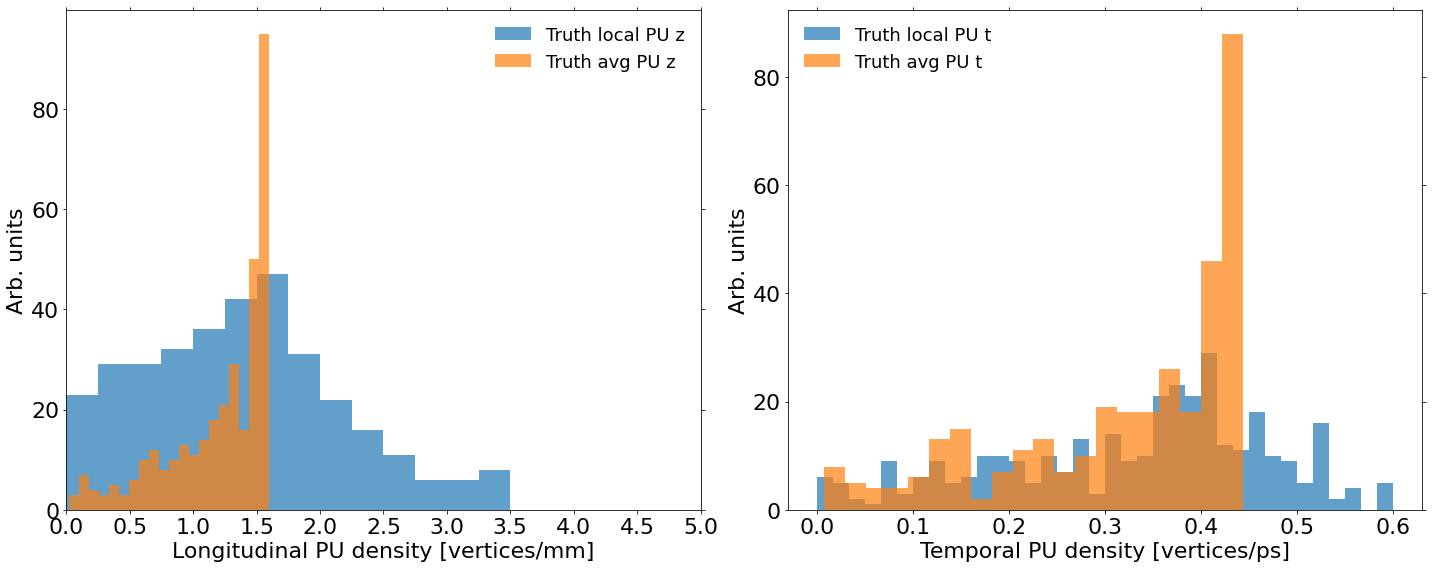

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

delta_z = 2
truth_localzPU = computeLocalPUDensity(truth_vertex_z, delta_z)
truth_avgzPU = computeAvgPUDensity(truth_vertex_z, mu=200, sigma_x=50)


zbinwidth = 1/(2*delta_z)
_, zLPU_truth_bin_edges, _ = ax1.hist(truth_localzPU, bins=np.arange(np.min(truth_localzPU), np.max(truth_localzPU) + zbinwidth, zbinwidth), density=False, alpha=0.7, label='Truth local PU z')
_, zAPU_truth_bin_edges, _ = ax1.hist(truth_avgzPU, bins=20, density=False, alpha=0.7, label='Truth avg PU z')

ax1.set_xlabel('Longitudinal PU density [vertices/mm]')
ax1.set_ylabel('Arb. units')
# ax1.set_yscale('log')
ax1.set_xticks(np.arange(0, 10, 0.5))
ax1.set_xlim(0, 5)
ax1.legend(frameon=False)


sigma_t = 180
delta_t = 60
truth_localtPU = computeLocalPUDensity(1e3*truth_vertex_t, delta_t)
truth_avgtPU = computeAvgPUDensity(1e3*truth_vertex_t, mu=200, sigma_x=sigma_t)

tbinwidth = 1/(2*delta_t) * 2
_, tLPU_truth_bin_edges, _ = ax2.hist(truth_localtPU, bins=np.arange(np.min(truth_localtPU), np.max(truth_localtPU) + tbinwidth, tbinwidth), density=False, alpha=0.7, label='Truth local PU t', color='C0')
_, tAPU_truth_bin_edges, _ = ax2.hist(truth_avgtPU, bins=20, density=False, alpha=0.7, label='Truth avg PU t', color='C1')

ax2.set_xlabel('Temporal PU density [vertices/ps]')
ax2.set_ylabel('Arb. units')
# ax2.set_yscale('log')
# ax2.set_xticks(np.arange(0, 0.5, 0.1))
# ax2.set_xlim(0, 0.5)
ax2.legend(frameon=False)
fig.tight_layout()

Text(0, 0.5, 'Avg z PU')

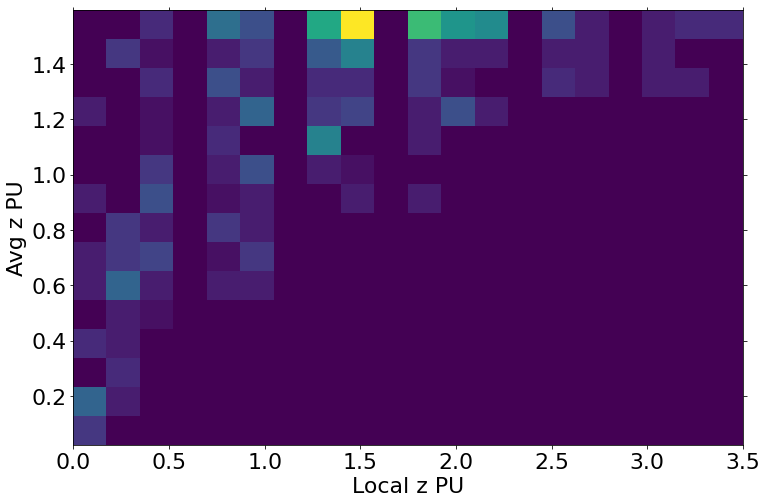

In [29]:
_  = plt.hist2d(truth_localzPU, truth_avgzPU, bins=(20, 15))
plt.xlabel('Local z PU')
plt.ylabel('Avg z PU')

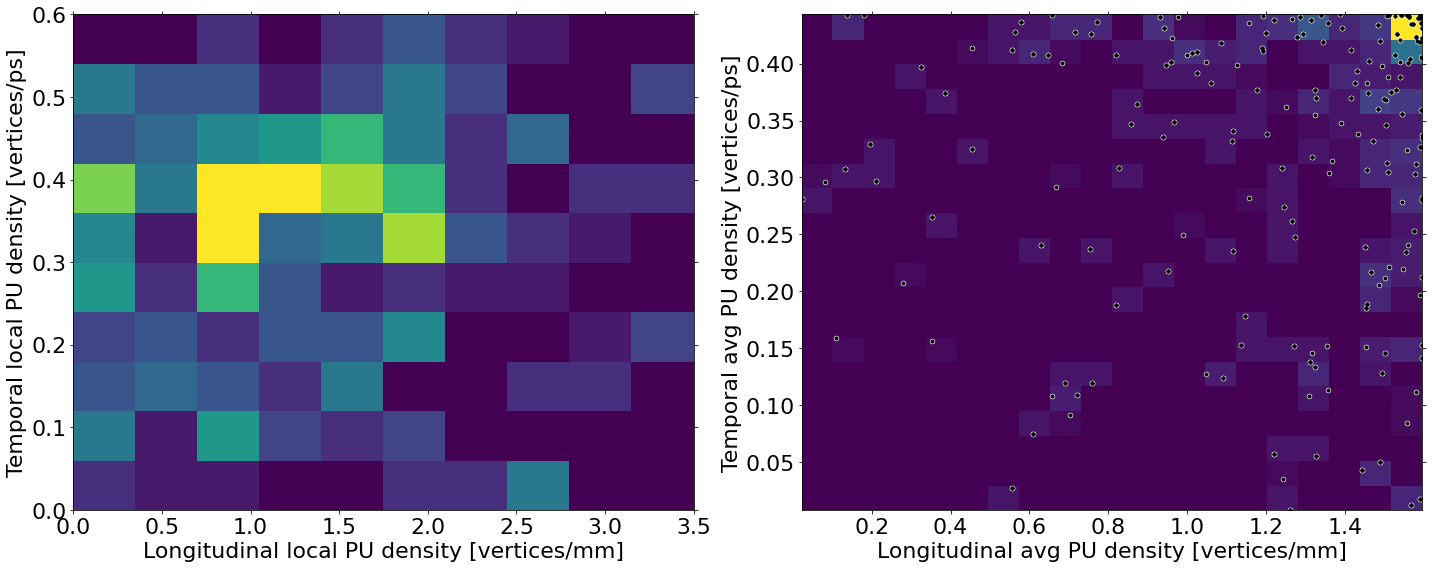

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

ax1.hist2d(truth_localzPU, truth_localtPU, bins=(10, 10))
ax1.set_xlabel('Longitudinal local PU density [vertices/mm]')
ax1.set_ylabel('Temporal local PU density [vertices/ps]')
# ax1.set_xlim(0, 1.65)
# ax1.set_ylim(0, 0.45)

ax2.hist2d(truth_avgzPU, truth_avgtPU, bins=(20, 20))
ax2.scatter(truth_avgzPU, truth_avgtPU, c='w', s=20)
ax2.scatter(truth_avgzPU, truth_avgtPU, c='k', s=10)
ax2.set_xlabel('Longitudinal avg PU density [vertices/mm]')
ax2.set_ylabel('Temporal avg PU density [vertices/ps]')
# ax2.set_xlim(0, 1.65)
# ax2.set_ylim(0, 0.45)

fig.tight_layout()

In [31]:
events_in_zLPU_bins = []
for bin in zLPU_truth_bin_edges:
    events_in_zLPU_bins.append(np.argwhere(np.isclose(truth_localzPU, bin)))
events_in_tLPU_bins = []
for bin in tLPU_truth_bin_edges:
    events_in_tLPU_bins.append(np.argwhere(np.isclose(truth_localtPU, bin)))

events_in_zAPU_bins = []
for i, bin in enumerate(zAPU_truth_bin_edges[1:]):
    events_in_zAPU_bins.append(np.argwhere(np.logical_and(truth_avgzPU > zAPU_truth_bin_edges[i-1], truth_avgzPU < bin)))
events_in_tAPU_bins = []
for i, bin in enumerate(tAPU_truth_bin_edges[1:]):
    events_in_tAPU_bins.append(np.argwhere(np.logical_and(truth_avgtPU > tAPU_truth_bin_edges[i-1], truth_avgtPU < bin)))

In [32]:
weighted_vs_fit_delta_z = []
weight_cut_vs_fit_delta_z = []

weighted_vs_truth_delta_z = []
weight_cut_vs_truth_delta_z = []

for event_idxs in events_in_zLPU_bins:
    bin_weighted_vs_fit_delta_z = []
    bin_weight_cut_vs_fit_delta_z = []
    bin_weighted_vs_truth_delta_z = []
    bin_weight_cut_vs_truth_delta_z = []
    
    for idx in event_idxs:
        idx = idx[0]
        reco_idx = 0
        weighted_reco_z = np.average(track_z0[idx][reco_vertex_track_idxs[idx][reco_idx]], weights=np.array(reco_vertex_track_weights[idx][reco_idx]))
        
        bin_weighted_vs_fit_delta_z.append(weighted_reco_z - reco_vertex_z[idx][reco_idx])
        weight_cut_idx = np.array(reco_vertex_track_weights[idx][reco_idx]) > 0.9
        weight_cut_reco_z = np.average(track_z0[idx][reco_vertex_track_idxs[idx][reco_idx]][weight_cut_idx], weights=np.array(reco_vertex_track_weights[idx][reco_idx][weight_cut_idx]))
        bin_weight_cut_vs_fit_delta_z.append(weight_cut_reco_z - reco_vertex_z[idx][reco_idx])
        
        reco_idx = truthHS_to_reco_link_idx[idx]
        weighted_reco_z = np.average(track_z0[idx][reco_vertex_track_idxs[idx][reco_idx]], weights=np.array(reco_vertex_track_weights[idx][reco_idx]))
        bin_weighted_vs_truth_delta_z.append(weighted_reco_z - truth_vertex_z[idx][0])
        weight_cut_idx = np.array(reco_vertex_track_weights[idx][reco_idx]) > 0.9
        weight_cut_reco_z = np.average(track_z0[idx][reco_vertex_track_idxs[idx][reco_idx]][weight_cut_idx], weights=np.array(reco_vertex_track_weights[idx][reco_idx][weight_cut_idx]))
        bin_weight_cut_vs_truth_delta_z.append(weight_cut_reco_z - truth_vertex_z[idx][0])
        
        
    weighted_vs_fit_delta_z.append(bin_weighted_vs_fit_delta_z)
    weight_cut_vs_fit_delta_z.append(bin_weight_cut_vs_fit_delta_z)
    weighted_vs_truth_delta_z.append(bin_weighted_vs_truth_delta_z)
    weight_cut_vs_truth_delta_z.append(bin_weight_cut_vs_truth_delta_z)
## 1/sigma^2

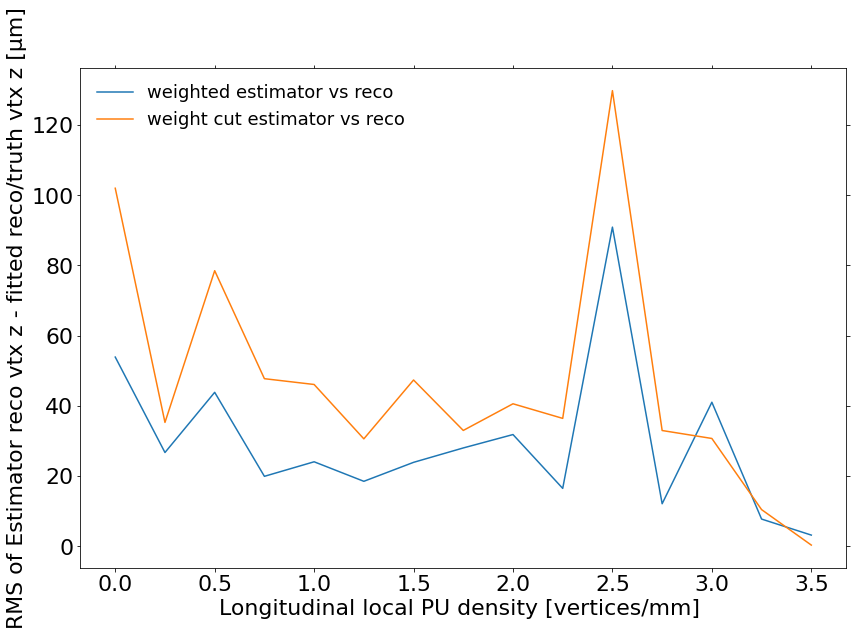

In [33]:
plt.plot(zLPU_truth_bin_edges, 1e3*np.array([np.std(delta_z) for delta_z in weighted_vs_fit_delta_z]), label='weighted estimator vs reco')
plt.plot(zLPU_truth_bin_edges, 1e3*np.array([np.std(delta_z) for delta_z in weight_cut_vs_fit_delta_z]), label='weight cut estimator vs reco')
# plt.plot(truth_bin_edges, 1e3*np.array([np.std(delta_z) for delta_z in weighted_vs_truth_delta_z]), label='weighted estimator vs truth')
# plt.plot(truth_bin_edges, 1e3*np.array([np.std(delta_z) for delta_z in weight_cut_vs_truth_delta_z]), label='weight cut estimator vs truth')

plt.xlabel('Longitudinal local PU density [vertices/mm] ')
plt.ylabel('RMS of Estimator reco vtx z - fitted reco/truth vtx z [µm]')
plt.legend(frameon=False, loc='upper left')
plt.tight_layout()

In [13]:
def vtx_z_info(events_in_bins, truth_vtx_idx_in_bins, all_truth_vtx_z, reco_vtx_idx_in_bins, all_reco_track_idxs, all_reco_track_weights, all_track_z0, sigma_cut, weight_cut):
    track_delta_z = []
    track_delta_z_rms = []
    
    track_weight_cut_delta_z = []
    track_weight_cut_delta_z_rms = []
    
    track_sigma_cut_delta_z = []
    track_sigma_cut_delta_z_rms = []
    
    track_vtx_z_res = []
    track_vtx_z_res_weight_cut = []
    track_vtx_z_res_sigma_cut = []
    track_vtx_z_res_std = []
    track_vtx_z_res_std_weight_cut = []
    track_vtx_z_res_std_sigma_cut = []
    
    vtx_delta_z = []
    vtx_weighted_delta_z = []
    vtx_weight_cut_delta_z = []
    
    vtx_z_res = []
    vtx_weighted_z_res = []
    vtx_weight_cut_z_res = []
    vtx_weight_cut_weighted_z_res = []
    vtx_sigma_cut_weighted_z_res = []
    vtx_z_res_tracks_sigma_cut = []
    vtx_weighted_z_res_tracks_sigma_cut = []

    vtx_z_res_std = []
    vtx_weighted_z_res_std = []
    vtx_weight_cut_z_res_std = []
    vtx_weight_cut_weighted_z_res_std = []
    vtx_sigma_cut_weighted_z_res_std = []
    vtx_z_res_std_tracks_sigma_cut = []
    vtx_weighted_z_res_std_tracks_sigma_cut = []

    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs, truth_vtx_idxs, reco_vtx_idxs in zip(events_in_bins, truth_vtx_idx_in_bins, reco_vtx_idx_in_bins):
        bin_track_delta_z = np.array([])
        bin_track_delta_z_rms = []
        
        bin_vtx_delta_z = []
        bin_vtx_weighted_delta_z = []
        
        bin_track_weight_cut_delta_z = np.array([])
        bin_track_weight_cut_delta_z_rms = []
        
        bin_vtx_weight_cut_delta_z = []
        bin_vtx_weight_cut_weighted_delta_z = []
        
        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            idx = idx[0]
            reco_track_z = all_track_z0[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_weights = all_reco_track_weights[idx][reco_idx]
            bin_reco_n_tracks.append(len(reco_track_z))
            
            truth_z = all_truth_vtx_z[idx][truth_idx]
            event_track_delta_z = reco_track_z - truth_z
            
            bin_track_delta_z = np.concatenate((bin_track_delta_z, event_track_delta_z))
            bin_track_delta_z_rms.append(np.sqrt(np.mean(event_track_delta_z**2)))
            
            reco_vtx_z = np.mean(reco_track_z)
            reco_vtx_weighted_z = np.average(reco_track_z, weights=reco_track_weights)
            
            bin_vtx_delta_z.append(reco_vtx_z - truth_z)
            bin_vtx_weighted_delta_z.append(reco_vtx_weighted_z - truth_z)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            weight_cut_track_z = reco_track_z[weight_cut_idx]
            bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_z))
            
            weight_cut_event_delta_z = weight_cut_track_z - truth_z
        
            bin_track_weight_cut_delta_z = np.concatenate((bin_track_weight_cut_delta_z, weight_cut_event_delta_z))
            bin_track_weight_cut_delta_z_rms.append(np.sqrt(np.mean(weight_cut_event_delta_z**2)))
            
            weight_cut_vtx_z = np.mean(weight_cut_track_z)
            weight_cut_vtx_weighted_z = np.average(weight_cut_track_z, weights = reco_track_weights[weight_cut_idx])
            
            bin_vtx_weight_cut_delta_z.append(weight_cut_vtx_z - truth_z)
            bin_vtx_weight_cut_weighted_delta_z.append(weight_cut_vtx_weighted_z - truth_z)
        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_z.append(bin_track_delta_z)
        track_delta_z_rms.append(bin_track_delta_z_rms)
        track_weight_cut_delta_z.append(bin_track_weight_cut_delta_z)
        track_weight_cut_delta_z_rms.append(bin_track_weight_cut_delta_z_rms)
        
        track_vtx_z_res.append(np.mean(bin_track_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_z_res_std.append(np.std(bin_track_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks)), ddof=1)/np.sqrt(len(bin_reco_n_tracks)))
        track_vtx_z_res_weight_cut.append(np.mean(bin_track_weight_cut_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        track_vtx_z_res_std_weight_cut.append(np.std(bin_track_weight_cut_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut)), ddof=1)/np.sqrt(len(bin_track_weight_cut_delta_z_rms)))
        
        
        vtx_delta_z.append(bin_vtx_delta_z)
        vtx_weighted_delta_z.append(bin_vtx_weighted_delta_z)
        vtx_weight_cut_delta_z.append(bin_vtx_weight_cut_delta_z)
        
        vtx_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z)**2)))
        vtx_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_z)**2)))
        vtx_weight_cut_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_z)**2)))
        vtx_weight_cut_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_z)**2)))
        
        bin_vtx_weighted_delta_z_sigma = np.std(bin_vtx_weighted_delta_z, ddof=1)
        bin_vtx_delta_z_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_z - np.mean(bin_vtx_weighted_delta_z)) < sigma_cut*bin_vtx_weighted_delta_z_sigma
        vtx_sigma_cut_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_z)[bin_vtx_delta_z_sigma_cut_idxs]**2)))
        
        
        ## Sigma cutting on tracks both for track based estimate on vtx z res and estimator of vtx z 
        bin_track_sigma = np.std(bin_track_delta_z)
        bin_track_sigma_cut_delta_z = []
        bin_track_sigma_cut_delta_z_rms = []
        bin_reco_n_tracks_sigma_cut = []
        
        bin_vtx_delta_z_tracks_sigma_cut = []
        bin_vtx_weighted_delta_z_tracks_sigma_cut = []
        
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            idx = idx[0]
            reco_track_z = all_track_z0[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_weights = all_reco_track_weights[idx][reco_idx]
            
            truth_z = all_truth_vtx_z[idx][truth_idx]
            event_track_delta_z = reco_track_z - truth_z
            
            track_sigma_cut_idx = np.abs(event_track_delta_z - np.mean(event_track_delta_z)) < sigma_cut*bin_track_sigma
            event_track_delta_z_sigma_cut = event_track_delta_z[track_sigma_cut_idx]
            
            bin_track_sigma_cut_delta_z.append(event_track_delta_z)
            bin_track_sigma_cut_delta_z_rms.append(np.sqrt(np.mean(event_track_delta_z**2)))
            bin_reco_n_tracks_sigma_cut.append(len(event_track_delta_z_sigma_cut))
            
            reco_vtx_z_sigma_cut_tracks = np.mean(reco_track_z[track_sigma_cut_idx])
            reco_vtx_weighted_z_sigma_cut_tracks = np.average(reco_track_z[track_sigma_cut_idx], weights=reco_track_weights[track_sigma_cut_idx])
            
            bin_vtx_delta_z_tracks_sigma_cut.append(reco_vtx_z_sigma_cut_tracks - truth_z)
            bin_vtx_weighted_delta_z_tracks_sigma_cut.append(reco_vtx_weighted_z_sigma_cut_tracks - truth_z)
        
        track_sigma_cut_delta_z.append(bin_track_sigma_cut_delta_z)
        track_sigma_cut_delta_z_rms.append(bin_track_sigma_cut_delta_z_rms)
        track_vtx_z_res_sigma_cut.append(np.mean(bin_track_sigma_cut_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks_sigma_cut))))
        track_vtx_z_res_std_sigma_cut.append(np.std(bin_track_sigma_cut_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks_sigma_cut)), ddof=1)/np.sqrt(len(bin_reco_n_tracks_sigma_cut)))
        
        vtx_z_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z_tracks_sigma_cut)**2)))
        vtx_weighted_z_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_z_tracks_sigma_cut)**2)))
        
        # Compute bootstrap std deviations
        bootstrap_vtx_z_res = []
        bootstrap_vtx_weighted_z_res = []
        bootstrap_vtx_weight_cut_z_res = []
        bootstrap_vtx_weight_cut_weighted_z_res = []
        
        bootstrap_vtx_z_res_tracks_sigma_cut = []
        bootstrap_vtx_weighted_z_res_tracks_sigma_cut = []
        for _ in range(int(1e3)):
            bin_vtx_delta_z_idx = np.random.randint(0, len(bin_vtx_delta_z), len(bin_vtx_delta_z))
            bootstrap_vtx_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z)[bin_vtx_delta_z_idx]**2)))
            
            bin_vtx_weighted_delta_z_idx = np.random.randint(0, len(bin_vtx_weighted_delta_z), len(bin_vtx_weighted_delta_z))
            bootstrap_vtx_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_z)[bin_vtx_weighted_delta_z_idx]**2)))
            
            bin_vtx_weight_cut_delta_z_idx = np.random.randint(0, len(bin_vtx_weight_cut_delta_z), len(bin_vtx_weight_cut_delta_z))
            bootstrap_vtx_weight_cut_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_z)[bin_vtx_weight_cut_delta_z_idx]**2)))
            
            bin_vtx_weight_cut_weighted_delta_z_idx = np.random.randint(0, len(bin_vtx_weight_cut_weighted_delta_z), len(bin_vtx_weight_cut_weighted_delta_z))
            bootstrap_vtx_weight_cut_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_z)[bin_vtx_weight_cut_weighted_delta_z_idx]**2)))
            
            bin_vtx_delta_z_tracks_sigma_cut_idx = np.random.randint(0, len(bin_vtx_delta_z_tracks_sigma_cut), len(bin_vtx_delta_z_tracks_sigma_cut))
            bootstrap_vtx_z_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z_tracks_sigma_cut)[bin_vtx_delta_z_tracks_sigma_cut_idx]**2)))
            
            bin_vtx_weighted_delta_z_tracks_sigma_cut_idx = np.random.randint(0, len(bin_vtx_weighted_delta_z_tracks_sigma_cut), len(bin_vtx_weighted_delta_z_tracks_sigma_cut))
            bootstrap_vtx_weighted_z_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z_tracks_sigma_cut)[bin_vtx_weighted_delta_z_tracks_sigma_cut_idx]**2)))
        
        vtx_z_res_std.append(np.std(bootstrap_vtx_z_res, ddof=1))
        vtx_weighted_z_res_std.append(np.std(bootstrap_vtx_weighted_z_res, ddof=1))
        vtx_weight_cut_z_res_std.append(np.std(bootstrap_vtx_weight_cut_z_res, ddof=1))
        vtx_weight_cut_weighted_z_res_std.append(np.std(bootstrap_vtx_weight_cut_weighted_z_res, ddof=1))
        vtx_z_res_std_tracks_sigma_cut.append(np.std(bootstrap_vtx_z_res_tracks_sigma_cut, ddof=1))
        vtx_weighted_z_res_std_tracks_sigma_cut.append(np.std(bootstrap_vtx_weighted_z_res_tracks_sigma_cut, ddof=1))
        
        
    return  {
                'avg_n_tracks' : avg_n_tracks,
                'track_delta_z' : track_delta_z,
                'track_delta_z_rms' : track_delta_z_rms,
                'track_weight_cut_delta_z' : track_weight_cut_delta_z,
                'track_weight_cut_delta_z_rms' : track_weight_cut_delta_z_rms,
                'track_sigma_cut_delta_z' : track_sigma_cut_delta_z,
                'track_sigma_cut_delta_z_rms' : track_sigma_cut_delta_z_rms,
                'track_vtx_z_res' : track_vtx_z_res,
                'track_vtx_z_res_weight_cut' : track_vtx_z_res_weight_cut,
                'track_vtx_z_res_sigma_cut' : track_vtx_z_res_sigma_cut,
                'vtx_delta_z' : vtx_delta_z,
                'vtx_weighted_delta_z' : vtx_weighted_delta_z,
                'vtx_weight_cut_delta_z' : vtx_weight_cut_delta_z,
                'vtx_z_res' : vtx_z_res,
                'vtx_weighted_z_res' : vtx_weighted_z_res,
                'vtx_weight_cut_z_res' : vtx_weight_cut_z_res,
                'vtx_weight_cut_weighted_z_res' : vtx_weight_cut_weighted_z_res,
                'vtx_sigma_cut_weighted_z_res' : vtx_sigma_cut_weighted_z_res,
                'vtx_z_res_tracks_sigma_cut' : vtx_z_res_tracks_sigma_cut,
                'vtx_weighted_z_res_tracks_sigma_cut' : vtx_weighted_z_res_tracks_sigma_cut,
                'track_vtx_z_res_std' : track_vtx_z_res_std,
                'track_vtx_z_res_std_weight_cut' : track_vtx_z_res_std_weight_cut,
                'track_vtx_z_res_std_sigma_cut' : track_vtx_z_res_std_sigma_cut,
                'vtx_z_res_std' : vtx_z_res_std,
                'vtx_weighted_z_res_std' : vtx_weighted_z_res_std,
                'vtx_weight_cut_z_res_std' : vtx_weight_cut_z_res_std,
                'vtx_weight_cut_weighted_z_res_std' : vtx_weight_cut_weighted_z_res_std,
                'vtx_z_res_std_tracks_sigma_cut' : vtx_z_res_std_tracks_sigma_cut,
                'vtx_weighted_z_res_std_tracks_sigma_cut' : vtx_weighted_z_res_std_tracks_sigma_cut
            }
            
            
def closest_truth_vtx_z_info(events_in_PU_bins, all_truth_vtx_z, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_z0, sigma_cut, weight_cut):
    reco_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    truth_vtx_idx_in_PU_bins = [[np.argmin(np.abs(truth_vertex_z[idx[0]] - reco_vertex_z[idx[0]][0])) for idx in event_idx] for event_idx in events_in_PU_bins]
    return vtx_z_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_z, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_z0, sigma_cut, weight_cut)

def truth_to_reco_link_vtx_z_info(events_in_PU_bins, all_truthHS_to_reco_idx, all_truth_vtx_z, all_reco_track_idxs, all_reco_track_weights, all_track_z0, sigma_cut, weight_cut):
    truth_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    reco_vtx_idx_in_PU_bins = [[all_truthHS_to_reco_idx[idx[0]] for idx in event_idx] for event_idx in events_in_PU_bins]
    
    return vtx_z_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_z, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_z0, sigma_cut, weight_cut)
    

## TODO: write function to load root files into ram when needed instead of all at once 
    


In [34]:
sigma_cut = 2
weight_cut = 0.9

ct_zLPU_vtx_z_info = closest_truth_vtx_z_info(events_in_zLPU_bins, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, reco_vertex_z, track_z0, sigma_cut, weight_cut)

link_zLPU_vtx_z_info = truth_to_reco_link_vtx_z_info(events_in_zLPU_bins, truthHS_to_reco_link_idx, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, track_z0, sigma_cut, weight_cut)

link_tLPU_vtx_z_info = truth_to_reco_link_vtx_z_info(events_in_tLPU_bins, truthHS_to_reco_link_idx, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, track_z0, sigma_cut, weight_cut)

link_zAPU_vtx_z_info = truth_to_reco_link_vtx_z_info(events_in_zAPU_bins, truthHS_to_reco_link_idx, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, track_z0, sigma_cut, weight_cut)

link_tAPU_vtx_z_info = truth_to_reco_link_vtx_z_info(events_in_tAPU_bins, truthHS_to_reco_link_idx, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, track_z0, sigma_cut, weight_cut)


/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/_methods.py:257: Ru

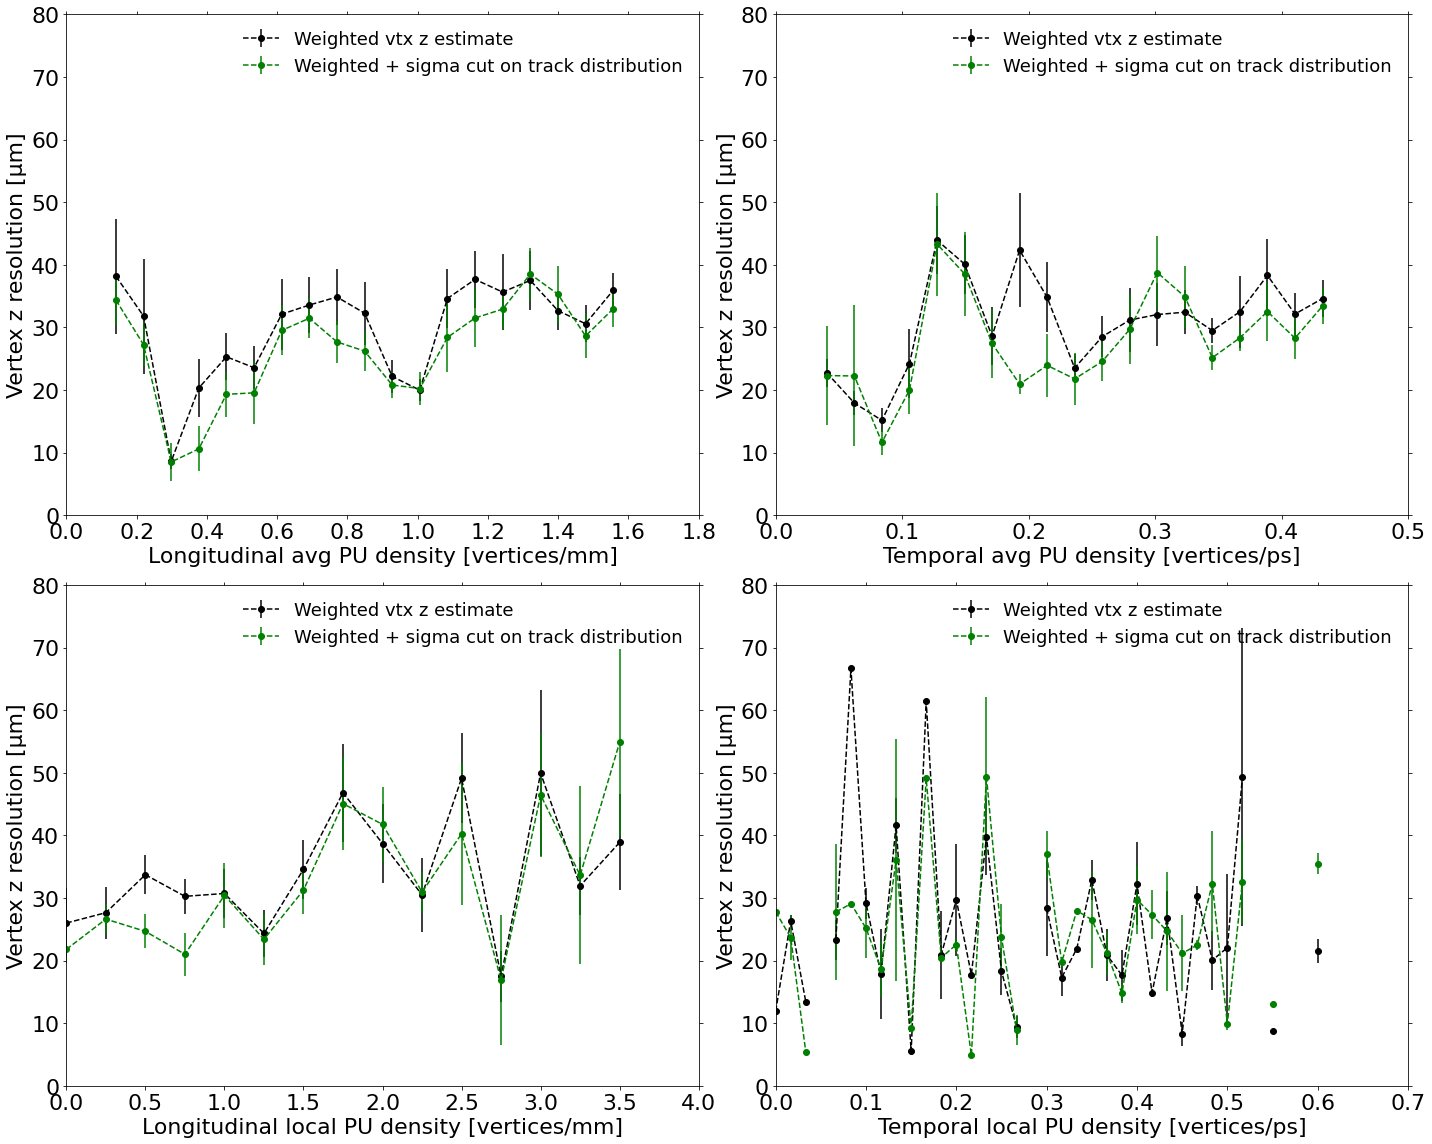

In [35]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges)/2, 1e3*np.array(link_zAPU_vtx_z_info['vtx_weighted_z_res']), \
                1e3*np.array(link_zAPU_vtx_z_info['vtx_weighted_z_res_std']), fmt='ko--', label='Weighted vtx z estimate')
                
# ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges)/2, 1e3*np.array(link_zAPU_vtx_z_info['vtx_weight_cut_z_res']), \
#                 1e3*np.array(link_zAPU_vtx_z_info['vtx_weight_cut_z_res_std']), fmt='ro--', label='Track weight cut')
                
# ax1.plot(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges)/2, 1e3*np.array(link_zAPU_vtx_z_info['vtx_sigma_cut_weighted_z_res']), 'bo--', label='Weighted + sigma cut on vtx distribution')

ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges)/2, 1e3*np.array(link_zAPU_vtx_z_info['vtx_weighted_z_res_tracks_sigma_cut']), \
                1e3*np.array(link_zAPU_vtx_z_info['vtx_weighted_z_res_std_tracks_sigma_cut']), fmt='go--', label='Weighted + sigma cut on track distribution')

ax1.set_xlim(0, 1.8)
ax1.set_ylim(0, 80)

ax1.set_xlabel('Longitudinal avg PU density [vertices/mm]')
ax1.set_ylabel('Vertex z resolution [µm]')
ax1.legend(frameon=False)

ax2.errorbar(tAPU_truth_bin_edges[1:]-np.diff(tAPU_truth_bin_edges)/2, 1e3*np.array(link_tAPU_vtx_z_info['vtx_weighted_z_res']), \
                1e3*np.array(link_tAPU_vtx_z_info['vtx_weighted_z_res_std']), fmt='ko--', label='Weighted vtx z estimate')
# ax2.errorbar(tAPU_truth_bin_edges[1:]-np.diff(tAPU_truth_bin_edges)/2, 1e3*np.array(link_tAPU_vtx_z_info['vtx_weight_cut_z_res']), \
#                 1e3*np.array(link_tAPU_vtx_z_info['vtx_weight_cut_z_res_std']), fmt='ro--', label='Track weight cut')
ax2.errorbar(tAPU_truth_bin_edges[1:]-np.diff(tAPU_truth_bin_edges)/2, 1e3*np.array(link_tAPU_vtx_z_info['vtx_weighted_z_res_tracks_sigma_cut']), \
                1e3*np.array(link_tAPU_vtx_z_info['vtx_weighted_z_res_std_tracks_sigma_cut']), fmt='go--', label='Weighted + sigma cut on track distribution')

# ax2.plot(tAPU_truth_bin_edges[1:]-np.diff(tAPU_truth_bin_edges)/2, 1e3*np.array(link_tAPU_vtx_z_info['vtx_sigma_cut_weighted_z_res']), 'bo--', label='Weighted + sigma cut on vtx distribution')

ax2.set_xlim(0, 0.5)
ax2.set_ylim(0, 80)

ax2.set_xlabel('Temporal avg PU density [vertices/ps]')
ax2.set_ylabel('Vertex z resolution [µm]')
ax2.legend(frameon=False)


ax3.errorbar(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_z_info['vtx_weighted_z_res']), \
                1e3*np.array(link_zLPU_vtx_z_info['vtx_weighted_z_res_std']), fmt='ko--', label='Weighted vtx z estimate')
                
ax3.errorbar(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_z_info['vtx_weighted_z_res_tracks_sigma_cut']), \
                1e3*np.array(link_zLPU_vtx_z_info['vtx_weighted_z_res_std_tracks_sigma_cut']), fmt='go--', label='Weighted + sigma cut on track distribution')

ax3.set_xlim(0, 4)
ax3.set_ylim(0, 80)

ax3.set_xlabel('Longitudinal local PU density [vertices/mm]')
ax3.set_ylabel('Vertex z resolution [µm]')
ax3.legend(frameon=False)

ax4.errorbar(tLPU_truth_bin_edges, 1e3*np.array(link_tLPU_vtx_z_info['vtx_weighted_z_res']), \
                1e3*np.array(link_tLPU_vtx_z_info['vtx_weighted_z_res_std']), fmt='ko--', label='Weighted vtx z estimate')
ax4.errorbar(tLPU_truth_bin_edges, 1e3*np.array(link_tLPU_vtx_z_info['vtx_weighted_z_res_tracks_sigma_cut']), \
                1e3*np.array(link_tLPU_vtx_z_info['vtx_weighted_z_res_std_tracks_sigma_cut']), fmt='go--', label='Weighted + sigma cut on track distribution')

ax4.set_xlim(0, 0.7)
ax4.set_ylim(0, 80)

ax4.set_xlabel('Temporal local PU density [vertices/ps]')
ax4.set_ylabel('Vertex z resolution [µm]')
ax4.legend(frameon=False)

fig.tight_layout()

In [ ]:
# TODO: compute the distance between truth HS and closest vtx - bin and plot resolutions vs this

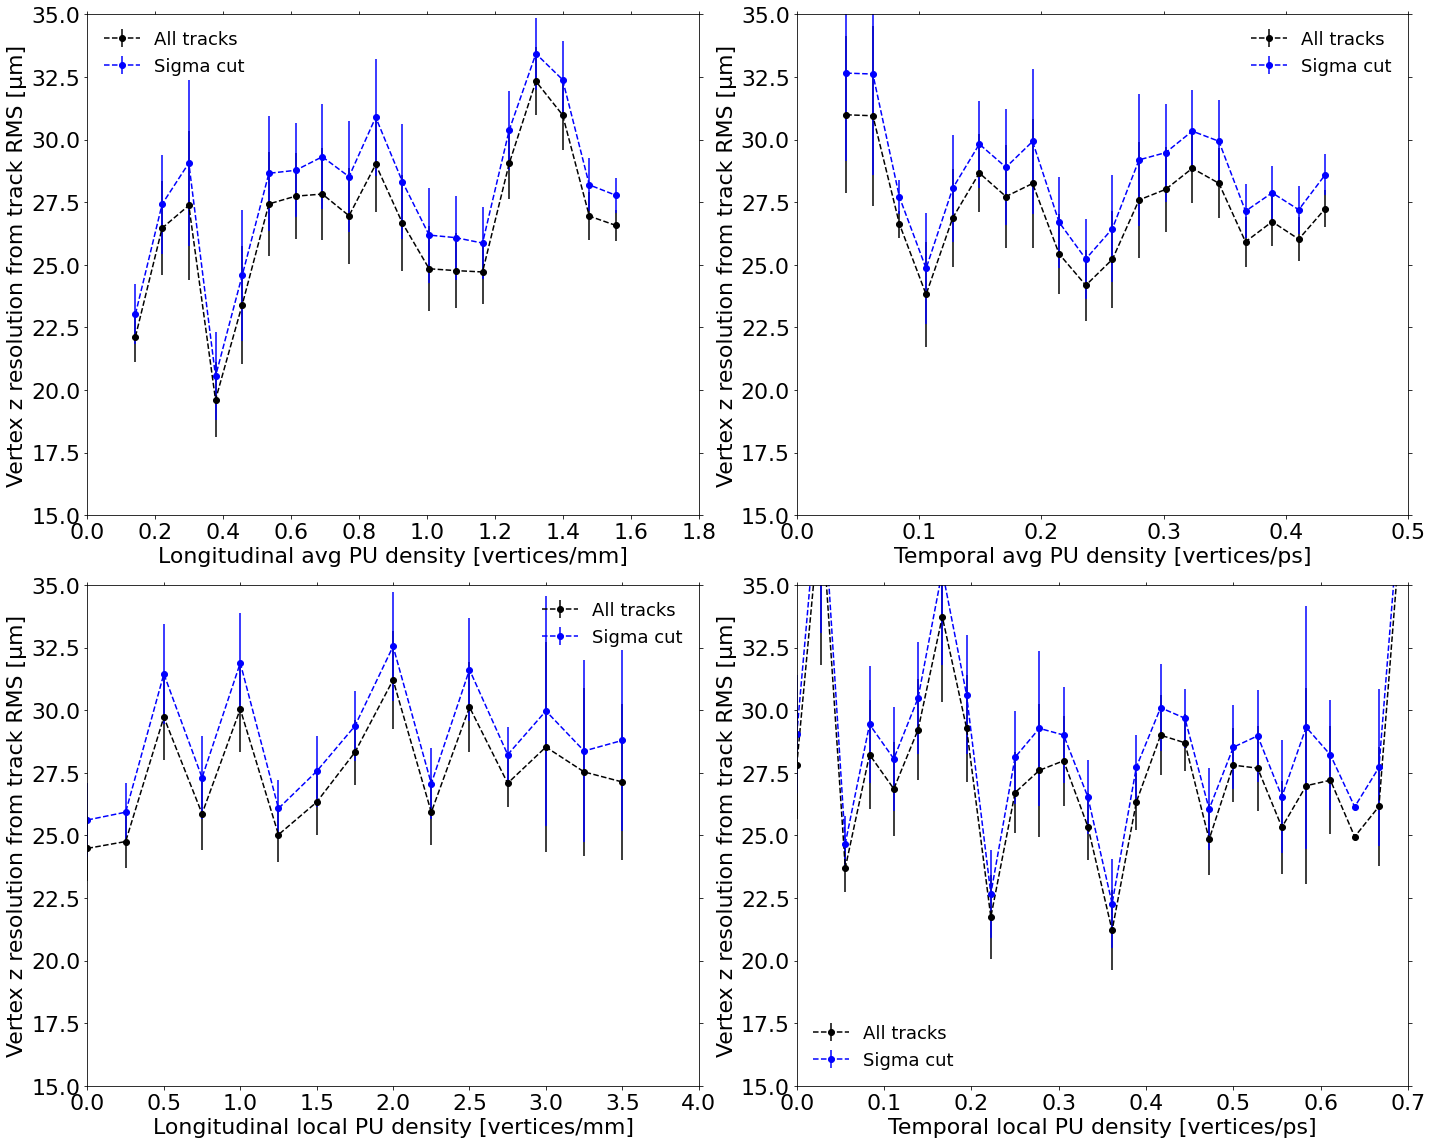

In [180]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges)/2, 1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res']),\
    1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_std']), fmt='ko--', label='All tracks')
# ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges)/2, 1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_weight_cut']),\
#     1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_std_weight_cut']), fmt='ro--', label='Weight cut')
ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges)/2, 1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_sigma_cut']),\
    1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_std_sigma_cut']), fmt='bo--', label='Sigma cut')

ax1.set_xlim(0, 1.8)
ax1.set_ylim(15, 35)

ax1.set_xlabel('Longitudinal avg PU density [vertices/mm]')
ax1.set_ylabel('Vertex z resolution from track RMS [µm]')
ax1.legend(frameon=False)

ax2.errorbar(tAPU_truth_bin_edges[1:]-np.diff(tAPU_truth_bin_edges)/2, 1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res']),\
    1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_std']), fmt='ko--', label='All tracks')
# ax2.errorbar(tAPU_truth_bin_edges[1:]-np.diff(tAPU_truth_bin_edges)/2, 1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_weight_cut']),\
#     1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_std_weight_cut']), fmt='ro--', label='Weight cut')
ax2.errorbar(tAPU_truth_bin_edges[1:]-np.diff(tAPU_truth_bin_edges)/2, 1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_sigma_cut']),\
    1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_std_sigma_cut']), fmt='bo--', label='Sigma cut')

ax2.set_xlim(0, 0.5)
ax2.set_ylim(15, 35)

ax2.set_xlabel('Temporal avg PU density [vertices/ps]')
ax2.set_ylabel('Vertex z resolution from track RMS [µm]')
ax2.legend(frameon=False)


ax3.errorbar(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_z_info['track_vtx_z_res']),\
    1e3*np.array(link_zLPU_vtx_z_info['track_vtx_z_res_std']), fmt='ko--', label='All tracks')
ax3.errorbar(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_z_info['track_vtx_z_res_sigma_cut']),\
    1e3*np.array(link_zLPU_vtx_z_info['track_vtx_z_res_std_sigma_cut']), fmt='bo--', label='Sigma cut')

ax3.set_xlim(0, 4)
ax3.set_ylim(15, 35)

ax3.set_xlabel('Longitudinal local PU density [vertices/mm]')
ax3.set_ylabel('Vertex z resolution from track RMS [µm]')
ax3.legend(frameon=False)

ax4.errorbar(tLPU_truth_bin_edges, 1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res']),\
    1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res_std']), fmt='ko--', label='All tracks')
# ax4.errorbar(tLPU_truth_bin_edges, 1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res_weight_cut']),\
#     1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res_std_weight_cut']), fmt='ro--', label='Weight cut')
ax4.errorbar(tLPU_truth_bin_edges, 1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res_sigma_cut']),\
    1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res_std_sigma_cut']), fmt='bo--', label='Sigma cut')

ax4.set_xlim(0, 0.7)
ax4.set_ylim(15, 35)

ax4.set_xlabel('Temporal local PU density [vertices/ps]')
ax4.set_ylabel('Vertex z resolution from track RMS [µm]')
ax4.legend(frameon=False)

fig.tight_layout()

Text(0.5, 0, 'Reco vtx track z - nearest truth vtx z [mm] ')

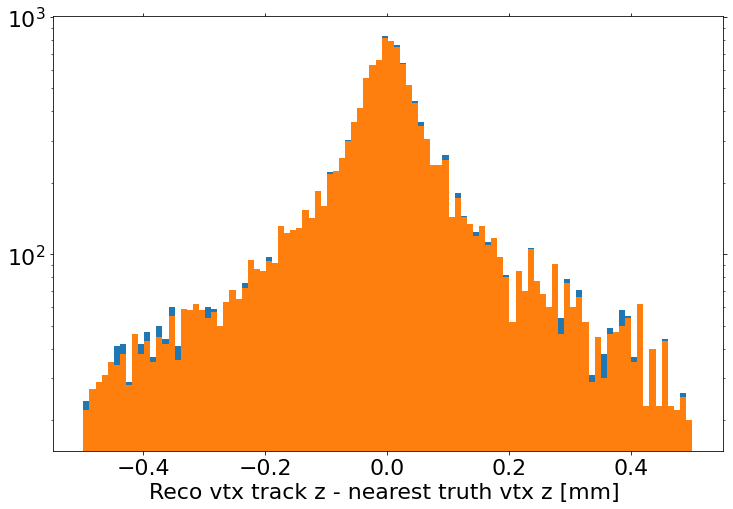

In [54]:
ct_track_delta_z_flat = np.concatenate(ct_zLPU_track_delta_z)
_  = plt.hist(ct_track_delta_z_flat[np.abs(ct_track_delta_z_flat) < 0.5], bins=100)

link_track_delta_z_flat = np.concatenate(link_zLPU_track_delta_z)
_  = plt.hist(link_track_delta_z_flat[np.abs(link_track_delta_z_flat) < 0.5], bins=100)

plt.yscale('log')
plt.xlabel('Reco vtx track z - nearest truth vtx z [mm] ')

In [ ]:
# fit core of gaussian
# plot sigma and rms
# see delta z w/o cut

# vertex z from avg track z w and w/o cut  

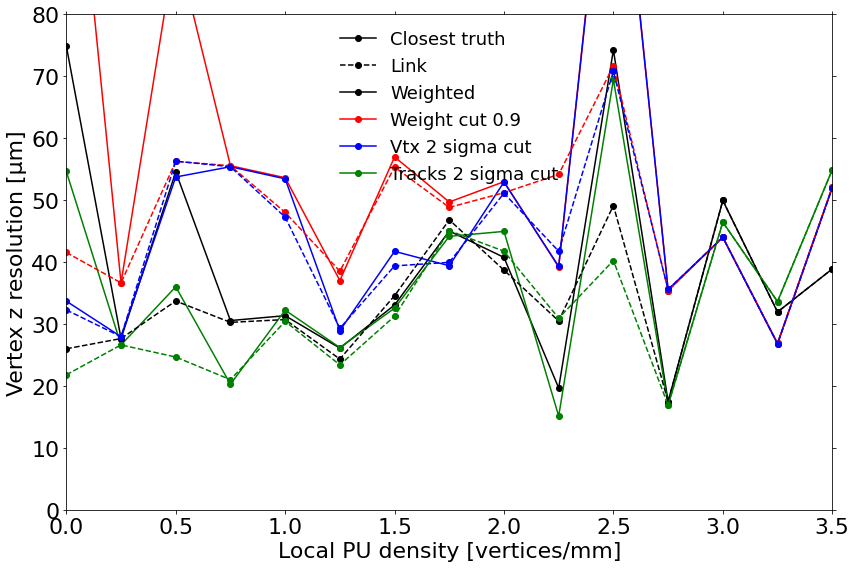

In [89]:
plt.plot([], [], 'ko-', label='Closest truth')
plt.plot([], [], 'ko--', label='Link')

plt.plot(zLPU_truth_bin_edges, 1e3*np.array(ct_zLPU_vtx_weighted_z_res), 'ko-', label='Weighted')
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(ct_zLPU_vtx_weight_cut_z_res), 'ro-', label='Weight cut {}'.format(0.9))
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(ct_zLPU_vtx_sigma_cut_weighted_z_res), 'bo-', label='Vtx {} sigma cut'.format(2))
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(ct_zLPU_vtx_weighted_z_res_tracks_sigma_cut), 'go-', label='Tracks {} sigma cut'.format(2))

plt.plot(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_weighted_z_res), 'ko--')
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_weight_cut_z_res), 'ro--')
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_sigma_cut_weighted_z_res), 'bo--')
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_weighted_z_res_tracks_sigma_cut), 'go--')



plt.xlim(0, 3.5)
plt.ylim(0, 80)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex z resolution [µm]')
plt.legend(frameon=False)
plt.tight_layout()

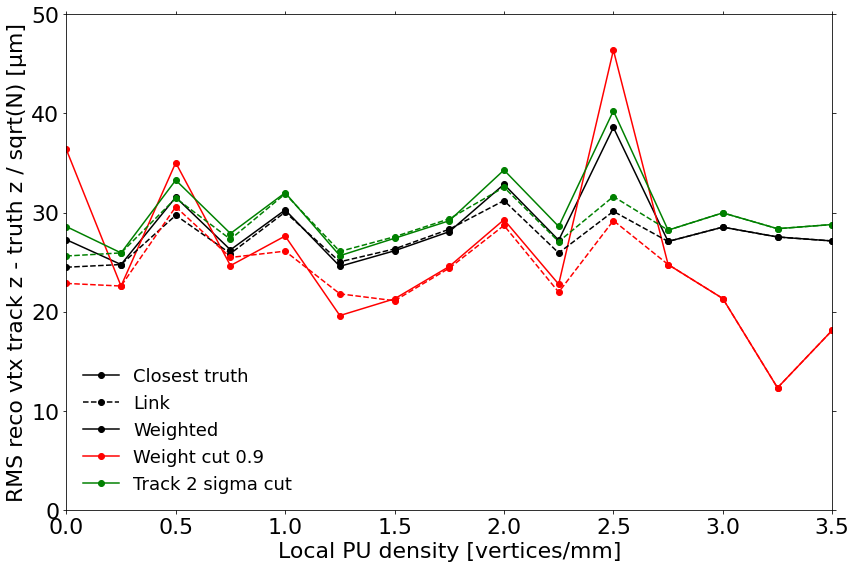

In [14]:
plt.plot([], [], 'ko-', label='Closest truth')
plt.plot([], [], 'ko--', label='Link')
plt.plot(truth_bin_edges, 1e3*np.array(ct_track_vtx_z_res), 'ko-', label='Weighted')
plt.plot(truth_bin_edges, 1e3*np.array(ct_track_vtx_z_res_weight_cut), 'ro-', label='Weight cut {}'.format(0.9))
plt.plot(truth_bin_edges, 1e3*np.array(ct_track_vtx_z_res_sigma_cut), 'go-', label='Track {} sigma cut'.format(2))

plt.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_z_res), 'ko--')
plt.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_z_res_weight_cut), 'ro--')
plt.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_z_res_sigma_cut), 'go--')


plt.xlim(0, 3.5)
plt.ylim(0, 50)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('RMS reco vtx track z - truth z / sqrt(N) [µm]')
plt.legend(frameon=False)
plt.tight_layout()

In [15]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_vtx_z_weighted_res), 'ko-', label='Unweighted')
# plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_vtx_z_res), 'bo-', label='Weighted avg')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_w_cut_vtx_z_res), 'ro-', label='Weight cut {}'.format(w_cut))


plt.xlim(0, 3.5)
# plt.ylim(0, 50)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('RMS reco vtx track z - truth z / sqrt(N) [µm]')
plt.legend(frameon=False)

NameError: name 'closest_truth_localPU_bins_vtx_z_weighted_res' is not defined

In [ ]:
# resolution vs distance to the closest truth vertex
# split into different eta regions

In [205]:
track_z0_var_recoHS = np.array([])
track_z0_var_truthHS = np.array([])
for idx in range(len(reco_vertex_track_idxs)):
    track_z0_var_recoHS = np.concatenate((track_z0_var_recoHS, track_z0_var[idx][reco_vertex_track_idxs[idx][0]]))
    track_z0_var_truthHS = np.concatenate((track_z0_var_truthHS, track_z0_var[idx][truth_vertex_track_idxs[idx][0]]))

Text(0.5, 0, 'track sigma_z0 [mm]')

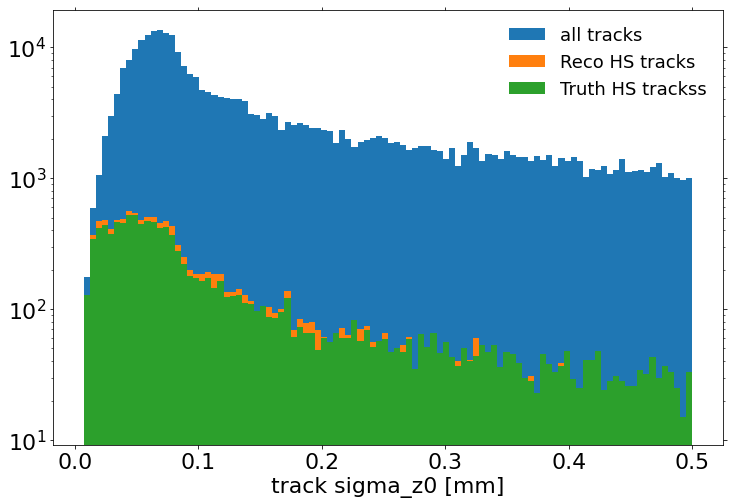

In [210]:
max_sigma = 0.5**2
_ = plt.hist(np.concatenate(track_z0_var)[np.concatenate(track_z0_var) < max_sigma]**0.5, bins=100, label='all tracks')
_ = plt.hist(track_z0_var_recoHS[track_z0_var_recoHS < max_sigma]**0.5, bins=100, label='Reco HS tracks')
_ = plt.hist(track_z0_var_truthHS[track_z0_var_truthHS < max_sigma]**0.5, bins=100, label='Truth HS trackss')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('track sigma_z0 [mm]')

In [ ]:
events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))
    
closest_truth_localPU_bins_delta_zs = []
closest_truth_localPU_bins_delta_z_rms_all = []
closest_truth_localPU_bins_vtx_z_res = []

closest_truth_localPU_bins_delta_z_weighted_rms_all = []
closest_truth_localPU_bins_vtx_z_weighted_res = []

w_cut = 0.9

closest_truth_localPU_bins_w_cut_delta_zs = []
closest_truth_localPU_bins_w_cut_delta_z_rms_all = []
closest_truth_localPU_bins_w_cut_vtx_z_res = []

for event_idxs in events_in_PU_bins:
    
    bin_closest_truth_delta_zs = np.array([])
    bin_closest_truth_delta_z_rms = []
    bin_closest_truth_delta_z_weighted_rms = []
    bin_closest_truth_n_tracks = []
    
    bin_closest_truth_w_cut_delta_zs = np.array([])
    bin_closest_truth_w_cut_delta_z_rms = []
    bin_closest_truth_w_cut_n_tracks = []
    
    for event_idx in event_idxs:
        event_idx = event_idx[0]
        reco_track_weights = reco_vertex_track_weights[event_idx][0]
        
        reco_vtx_z = reco_vertex_z[event_idx][0]
        closest_truth_z = truth_vertex_z[event_idx][np.argmin(np.abs(truth_vertex_z[event_idx] - reco_vtx_z))]
        
        delta_zs = track_z0[event_idx][reco_vertex_track_idxs[event_idx][0]] - closest_truth_z

        bin_closest_truth_delta_zs = np.concatenate((bin_closest_truth_delta_zs, delta_zs))
        bin_closest_truth_delta_z_rms.append(np.sqrt(np.mean(delta_zs**2)))
        bin_closest_truth_delta_z_weighted_rms.append(np.sqrt(np.average(delta_zs**2, weights=reco_track_weights)))
        bin_closest_truth_n_tracks.append(len(delta_zs))
        
        cut_idx = np.array(reco_track_weights) > w_cut
        bin_closest_truth_w_cut_delta_zs = np.concatenate((bin_closest_truth_delta_zs, delta_zs[cut_idx]))
        bin_closest_truth_w_cut_delta_z_rms.append(np.sqrt(np.average(delta_zs[cut_idx]**2)))
        bin_closest_truth_w_cut_n_tracks.append(len(delta_zs[cut_idx]))
        
    closest_truth_localPU_bins_delta_zs.append(bin_closest_truth_delta_zs)
    closest_truth_localPU_bins_delta_z_rms_all.append(bin_closest_truth_delta_z_rms)
    closest_truth_localPU_bins_vtx_z_res.append(np.mean(bin_closest_truth_delta_z_rms / np.sqrt(np.array(bin_closest_truth_n_tracks))))
    closest_truth_localPU_bins_delta_z_weighted_rms_all.append(bin_closest_truth_delta_z_weighted_rms)
    closest_truth_localPU_bins_vtx_z_weighted_res.append(np.mean(bin_closest_truth_delta_z_weighted_rms / np.sqrt(np.array(bin_closest_truth_n_tracks))))
    
    closest_truth_localPU_bins_w_cut_delta_zs.append(bin_closest_truth_w_cut_delta_zs)
    closest_truth_localPU_bins_w_cut_delta_z_rms_all.append(bin_closest_truth_w_cut_delta_z_rms)
    closest_truth_localPU_bins_w_cut_vtx_z_res.append(np.nanmean(bin_closest_truth_w_cut_delta_z_rms / np.sqrt(np.array(bin_closest_truth_w_cut_n_tracks))))